In this notebook we will look at the performance of the classifier with metrics
from the Python scikit-image library.

This notebook is using a subset of images held out from training, so the neural network
has not seen these images yet.

First thing, import the packages we will use.

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

Check that the installed version of Tensorflow is <= 1.15.5

In [2]:
tf.__version__

'1.15.5'

### Load images and labels

When the training ran, 10 percent of the images where held out and saved to a numpy file.
These will be used to test the performance. A commented out line with all of the images used
in training can be used if desired.

The images were normalized to have zero mean and a standard deviation of 1. This will need to be done now also.

In [3]:
data = np.load('Checkpoints/test/validation_images.npy')
_labels = np.load('Checkpoints/test/validation_labels.npy')

## use the following for all (trained/test/validation) in the dataset
#data = np.load('Data/snail_images.npy')
#labels = np.load('Data/snail_labels.npy')

def normalize(x):
    ''' Normalize the images to mean=0 and std=1
    
    Parameters
    ----------
    x : array
        Array of images, (?, y, x, channel)
        
    Returns
    -------
    xn : array
        normalized images
    '''
    
    xm = x.mean(axis=(1,2), keepdims=True)
    sm = x.std(axis=(1,2), keepdims=True)
    xn  = (x - xm)/sm
    return xn

data = normalize(data)

#check some data info
len(data), data.mean(), data.std()

(3548, 1.4111584e-09, 1.0000001)

### Look at some images

We can plot some images to verify they are loaded properly. Change image_num to see a different image

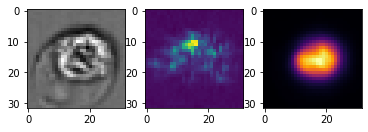

In [4]:
image_num = 152
fig, ax = plt.subplots(1,3, figsize=(6,2))
ax[0].imshow(data[image_num,:,:,0], cmap='gray')
ax[1].imshow(data[image_num,:,:,1])
ax[2].imshow(data[image_num,:,:,2], cmap='inferno')

### Combine classes

The training was performed by combining labeld clusters with similar morphology and overlap in the force-directed layout. The next cell will combine the classes. The labels are in a one-hot encoded format, so a cell labeled with cluster 2 will have a label \[0, 0, 1, 0, 0, 0, 0, 0, 0\]. 

In [5]:
# convert the one-hot encoded labels to a vector
d_labels = _labels.argmax(axis=1)

# where d_labels is equal to 8, replace it with 0, otherwise leave it
d_labels = np.where(d_labels == 8, 0, d_labels)
# where d_labels is equal to 7, replace it with 4, otherwise leave it
d_labels = np.where(d_labels == 7, 4, d_labels)

## Transform back into one-hot encoded format
bl = LabelBinarizer()
bl.fit(np.arange(7))
labels = bl.transform(d_labels)


### Tensorflow setup
This cell resets tensorflow, create a session and opens a trained model (checkpoint). The training saves a checkpoint at the iteration with the best accuracy, and also a checkpoint at the last iteration. Check the results of both to check how they compare.

In [6]:
## reset tensorflow and create a new session
tf.reset_default_graph()
sess = tf.Session()

## Last checkpoint
#checkpoint = 'Checkpoints/test/cp-2021-05-04-16-07/checkpoint-24999'

## best checkpoint
checkpoint = 'Checkpoints/test/best-2021-05-04-16-07/best-checkpoint-20500'

# Load the checkpoint into the Tensorflow session
cpmeta = checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from Checkpoints/test/best-2021-05-04-16-07/best-checkpoint-20500


In [7]:
'''
tensors \(arrays\) from the network need be be variables

softmax : the probability a cell belongs to each class this
          is the output of the network

images : the images input into the network
'''

softmax = sess.graph.get_tensor_by_name('Softmax:0')
images = sess.graph.get_tensor_by_name('Placeholder:0')

In [8]:
## check the shape of the tensors

images, softmax

(<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [9]:
## this will input the images into the network and
## return the softmax variable as numpy array of probabilies 
probs = sess.run(softmax, feed_dict={images:data})

## the prediction for each cell is the class with
## the highest probability
predictions = np.argmax(probs, axis=-1)

## put the results into a pandas datafrae
xdf = pd.DataFrame({'prediction':predictions,
                    'prob_max':probs.max(axis=-1), 'dataset':'snail'})
xdf['cluster'] = d_labels

In [10]:
## look at the probabilites for one of the cells
## the highest will be the prediction
probs[451]

array([9.6049118e-01, 6.4869889e-04, 2.4315679e-02, 2.4203390e-04,
       1.1818422e-03, 8.3171315e-03, 4.8033805e-03], dtype=float32)

In [11]:
## the prediction from the above probabilites
f"This predicted class is: {predictions[451]} with a probability of {probs[451].max()}"

'This predicted class is: 0 with a probability of 0.9604911804199219'

Text(0.5, 1.0, 'Labels')

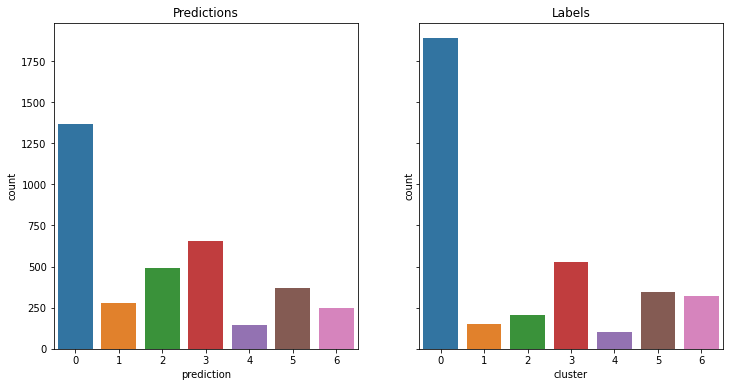

In [12]:
## checkout how the class distribution compares to the labels

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))
sns.countplot(data=xdf, x='prediction', ax=ax[0])
sns.countplot(data=xdf, x='cluster', ax=ax[1])
ax[0].set_title('Predictions')
ax[1].set_title('Labels')
#plt.yscale('log')

### Check performance

In [15]:
val_nums = labels.argmax(axis=1)
vsm_nums = probs.argmax(axis=1)
val_accuracy = metrics.accuracy_score(xdf.cluster, xdf.prediction)

val_cm = metrics.confusion_matrix(xdf.cluster, xdf.prediction)

val_report = metrics.classification_report(xdf.cluster, xdf.prediction)

print(f"The accuracy score is: {val_accuracy}\n")

print("Classification Report")
print("---------------------\n")
print(val_report)

print("Confusion Matrix")
print("----------------\n")
print(val_cm)

The accuracy score is: 0.6637542277339347

Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1889
           1       0.34      0.61      0.43       152
           2       0.32      0.77      0.45       205
           3       0.63      0.78      0.70       529
           4       0.41      0.57      0.47       104
           5       0.52      0.55      0.54       345
           6       0.62      0.47      0.53       324

    accuracy                           0.66      3548
   macro avg       0.54      0.63      0.56      3548
weighted avg       0.75      0.66      0.69      3548

Confusion Matrix
----------------

[[1287   40  266  156   18   71   51]
 [   0   93   22   24    3    8    2]
 [  19   10  157   13    1    4    1]
 [  14   47   26  415    4   11   12]
 [   5    2    1    0   59   34    3]
 [  21   47    6   11   43  191   26]
 [  19   37   13   36   17   49  153]]
